In [135]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## **1. Read data**

A list of all relevant congress members is pulled in, consisting of 183 members from both the House of Representatives and the Senate. Party affiliation and DW-Nomindate value is given, as well as information about their twitter account.

In [136]:
# Pull list of all 183 congressmembers
filepath = 'data/raw/congressmembers_characteristics.csv'
all_congress_members = pd.read_csv(filepath)
all_congress_members.head(5)

,Unnamed: 0,nameid,congressperson,first_name,last_name,gender,party,chamber,stdis,twitter_name,dw.nom.1,Barbera1_score,Jackman_score,Zhixiang_score
0,0,B000589,speakerboehner,John,Boehner,M,R,House,OH8,speakerboehner,0.516,0.869296,0.653032,0.597428
1,1,R000570,speakerryan,Paul,Ryan,M,R,House,WI1,reppaulryan,0.567,1.445708,0.949106,0.500000
2,2,P000197,speakerpelosi,Nancy,Pelosi,F,D,House,CA12,nancypelosi,-0.533,-1.454262,-1.363589,0.393234
3,3,B001256,michelebachmann,Michele,Bachmann,F,R,House,MN6,michelebachmann,0.579,1.364745,0.890506,0.623674
4,4,W000797,dwstweets,Debbie,Wasserman Schultz,F,D,House,FL23,dwstweets,NaN,NaN,-0.942929,0.365214


In [137]:
# Get list of the 163 (subset of 183) for whom following data has been collected
collected = pd.read_csv('data/interim/congress_master_following_table.csv')[['congressperson']].drop_duplicates()
all_congress_members_collected = all_congress_members.merge(collected, on='congressperson', how='inner').drop(['Unnamed: 0'], axis=1)
print(f'{len(all_congress_members_collected)} congressmembers loaded')

164 congressmembers loaded


## **2. Exploratory analysis**

Visualisations show the distribution of values for attributes such as party affiliation, DW-Nominate score, twitter statistics etc.

#### **2.1 Party, chamber**

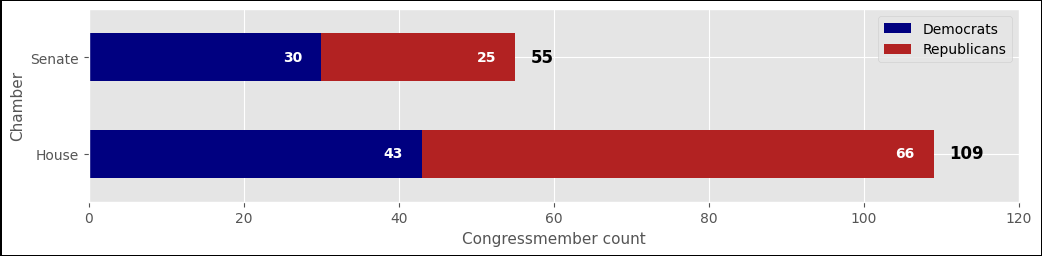

In [138]:
def plotChamberParty(df, figsize=(15, 6), save=False, fileformat='pdf'):
    with plt.style.context("ggplot"):

        df = df.sort_values(by='chamber', ascending=True)

        # Group by 'chamber' and 'party' and count occurrences
        counts = df.groupby(['chamber', 'party']).size().unstack(fill_value=0).sort_values(by='D', ascending=False)

            # Explicitly define a figure and set the size
        fig, ax= plt.subplots(figsize=figsize)  # Example size, adjust as needed


        # Plot a horizontal stacked bar chart
        counts.plot(kind='barh', stacked=True, color=['navy', 'firebrick'],figsize=figsize, alpha=1, ax=ax)
        plt.xlabel('Congressmember count', fontsize=11)
        plt.ylabel('Chamber', fontsize=11)
        #plt.title('Party Distribution by Chamber')
        legend_labels = ['Democrats', 'Republicans']  # Customize these to any descriptive labels
        ax.legend(labels=legend_labels)
        ax.set_xlim(0, 120)


        for rect in ax.patches:  # Iterate over all the bars
            width = rect.get_width()  # Get the width of each bar
            y = rect.get_y() + rect.get_height() / 2  # Get the y position to place the text
            x = rect.get_x() + width - 5  # Set a small offset from the end of the bar for the text
            label_text = int(width)  # The label will be the width of the bar
            ax.text(x, y, label_text, va='center', color='white', fontweight='bold') 

                # Add total labels to the end of the complete bars
        totals = counts.sum(axis=1)  # Calculate the total for each chamber
        for index, total in enumerate(totals):
            # Place the total at the end of each bar, align it a bit beyond the longest bar
            ax.text(total + 2, index, str(int(total)), va='center', fontweight='bold', zorder=3, fontsize=12)

                   # Add a border around the figure

        fig.patch.set_edgecolor('black')  # Set border color
        fig.patch.set_linewidth(1) 

        if save:
            current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
            plt.savefig('results/figures/exploratory_chamber_party_{}'.format(current_ts), bbox_inches='tight', dpi=400, format=fileformat)
        plt.show()

plotChamberParty(df=all_congress_members_collected,figsize=(12,2.5), save=False)

#### **2.2 DW-Nominate score**

Democrats mean: -0.43899999999999995
Democrats STD: 0.1326391286971475
Republican mean: 0.5043103448275862
Republican STD: 0.17687568294517358


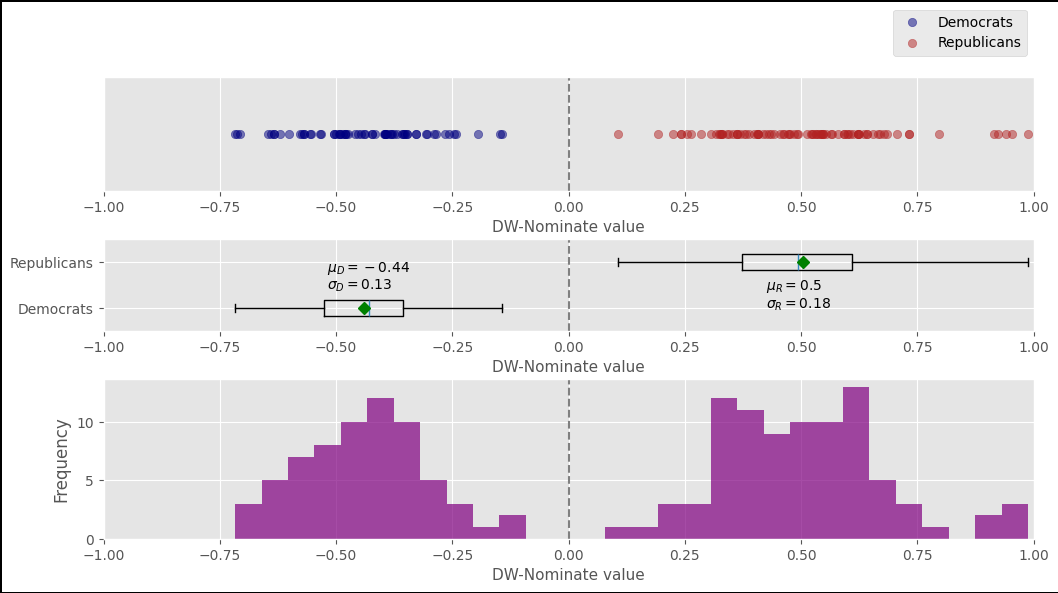

In [139]:
def plotDWSpectrum(df, score_col = 'dw.nom.1',figsize=(15, 6), save=False, fileformat='pdf'):
    # Create a figure with two subplots, vertically stacked, sharing the same x-axis
    with plt.style.context("ggplot"):
        fig, axs = plt.subplots(3, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios' : [1,0.8,1.4]})


        # First subplot: Plot DW-Nominate values
        democrats = df[df['party'] == 'D']
        republicans = df[df['party'] == 'R']

        democrat_mean = democrats[score_col].dropna().mean()
        democrat_std = democrats[score_col].dropna().std()

        republican_mean = republicans[score_col].dropna().mean()
        republican_std = republicans[score_col].dropna().std()



        axs[0].scatter(democrats[score_col], np.zeros(len(democrats)), color='navy', alpha=0.5, label='Democrats')
        axs[0].scatter(republicans[score_col], np.zeros(len(republicans)), color='firebrick', alpha=0.5, label='Republicans')
        axs[0].axvline(x=0, color='grey', linestyle='dashed')
        axs[0].legend(loc='upper right', bbox_to_anchor=(1,1.65))
        #axs[0].set_title('DW-Nominate values (first dimension)', fontsize=12)
        axs[0].set_xlabel('DW-Nominate value', fontsize=11)
        axs[0].set_yticks([])
        axs[0].tick_params(labelbottom=True) 
        axs[0].set_xlim([-1,1])

                    # Second subplot: Boxplot of DW-Nominate values
        axs[1].boxplot([democrats[score_col].dropna(), republicans[score_col].dropna()], vert=False, patch_artist=False, 
                    labels=['Democrats', 'Republicans'], whis=(0,100), widths=0.35, showmeans=True ,meanprops={'marker':'D', 'markerfacecolor' :'green', 'markeredgecolor' :'green'})
        axs[1].axvline(x=0, color='grey', linestyle='dashed')
        axs[1].set_xlabel('DW-Nominate value', fontsize=11)
        axs[1].tick_params(labelbottom=True) 

        axs[1].annotate(r'$\mu_D = {}$'.format(np.round(democrat_mean,2)), (democrat_mean-0.08,1.8))
        axs[1].annotate(r'$\sigma_D = {}$'.format(np.round(democrat_std,2)), (democrat_mean-0.08,1.4))

        axs[1].annotate(r'$\mu_R = {}$'.format(np.round(republican_mean,2)), (republican_mean-0.08,1.4))
        axs[1].annotate(r'$\sigma_R = {}$'.format(np.round(republican_std,2)), (republican_mean-0.08,1))

        # Second subplot: Histogram of DW-Nominate values
        axs[2].hist(df[score_col], bins=30, color='purple', alpha=0.7)
        axs[2].axvline(x=0, color='grey', linestyle='dashed')
        #axs[1].set_title('Histogram of DW-Nominate first dimension values', fontsize=12)
        axs[2].set_xlabel('DW-Nominate value', fontsize=11)
        axs[2].set_ylabel('Frequency')
        axs[2].tick_params(labelbottom=True) 

        print(f'Democrats mean: {democrat_mean}')
        print(f'Democrats STD: {democrat_std}')

        print(f'Republican mean: {republican_mean}')
        print(f'Republican STD: {republican_std}')

        fig.subplots_adjust(hspace=0.4)

            # Add a border around the figure
        fig.patch.set_edgecolor('black')  # Set border color
        fig.patch.set_linewidth(1)    

        # Save the figure if requested
        if save:
            current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
            plt.savefig('results/figures/exploratory_DW_spectrum_{}'.format(current_ts), bbox_inches='tight', dpi=400, format=fileformat)
        
        # Show the figure
        plt.show()


plotDWSpectrum(df = all_congress_members_collected, figsize=(12,6),save=False)